Adapted from : https://mne.tools/dev/auto_examples/simulation/simulate_evoked_data.html

In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
import xarray as xr
import pyhsmm_mvpa as hsmm
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
n_events = 500
sources = [['lateraloccipital-lh',1e-8, [150,50]],
           ['lateraloccipital-rh',1e-8, [300,50]],
           ['postcentral-lh', 1e-8, [500,50]],
           ['postcentral-lh', 1e-25, [100,20]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 3000#ms

bump_frequency = 10.

if 'simulated-raw.fif' in os.listdir():
    raw = mne.io.read_raw_fif('simulated-raw.fif')
    generating_events = np.load('generating_events.npy')
else:

    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    #fwd = fwd.pick_channels(info.ch_names[-61:])
    src = fwd['src']

    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep, first_samp=0, duration=(2+1*n_events+3)*max_trial_length*tstep)

    # stim_onset occurs every x samples.
    events = np.zeros((n_events, 3), int)
    stim_onsets =  2000+max_trial_length * np.arange(n_events)#2000 = offset of first stim
    events[:,0] = stim_onsets#last event 
    
    trigger = 1
    random_source_times = []
    generating_events = events
    for source in sources:
        selected_label = mne.read_labels_from_annot(
            subject, regexp=source[0], subjects_dir=subjects_dir)[0]
        label = mne.label.select_sources(
            subject, selected_label, location='center', extent=10,# Extent in mm of the region.
            subjects_dir=subjects_dir)

        # Define the time course of the activity for each source of the region to
        # activate.
        source_time_series = np.sin(2. * np.pi * bump_frequency * np.arange(25) * tstep) * source[1]

    
        #adding source event
        events = events.copy()
        random_source_times.append(np.random.normal(source[2][0],source[2][1],n_events)) #varying event 
        events[:, 0] = events[:,0] + random_source_times[-1] # Events sample.
        events[:, 2] = trigger  # All events have the sample id.
        trigger += 1
        generating_events = np.concatenate([generating_events, events])

        #add these events
        source_simulator.add_data(label, source_time_series, events)
 
    generating_events = generating_events[generating_events[:, 0].argsort()]
    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd, n_jobs=-1,verbose=False)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
    #raw.plot()

    raw.save('simulated-raw.fif',overwrite=True)
    np.save('generating_events.npy', generating_events)

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/gweindel/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading labels fro

In [58]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == 4)]

event_id = {'stimulus':0}
resp_id = {'response':4}
eeg_dat = hsmm.read_mne_EEG(['simulated-raw.fif'],event_id, resp_id, raw.info['sfreq'],events)
stacked, starts, ends, weights = hsmm.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, return_weights=True)
init = hsmm.hsmm(stacked.to_numpy().T, starts, ends, sf=eeg_dat.sfreq, bump_width=50)

# Estimating a 3 bump model

Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Parameters estimated for 3 bumps model


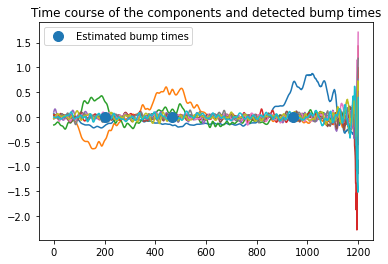

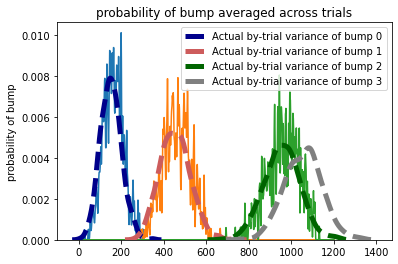

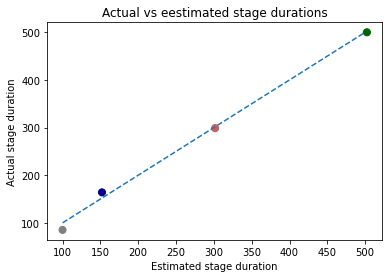

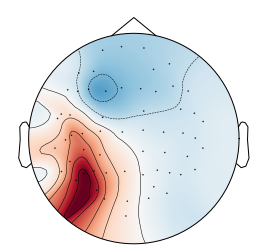

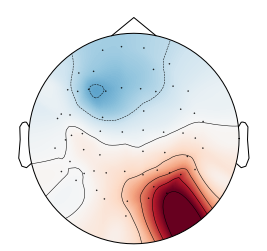

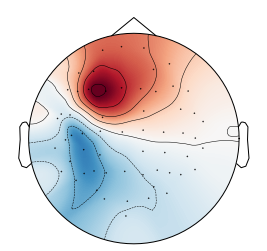

In [104]:
estimates = init.fit_single(3)
times = init.bump_times(estimates, time=False)
for comp in np.arange(10):
    plt.plot(stacked.unstack().mean(dim=['epochs'])[comp,:])
plt.plot(init.mean_bump_times(estimates,time=False), np.repeat(0,3),'o',label='Estimated bump times',markersize=10)
plt.title('Time course of the components and detected bump times')
plt.legend()
plt.show()

plt.plot(estimates.eventprobs.mean(dim=['trial']));
colors = ['darkblue','indianred','darkgreen','grey']
for i in range(len(random_source_times.T)):
    sns.kdeplot(np.sum(random_source_times[:,:i+1],axis=1),lw=5, color=colors[i]
                ,ls='--',label=f'Actual by-trial variance of bump {i}')
plt.legend()
plt.title('probability of bump averaged across trials')
plt.ylabel('probability of bump')
plt.show()


plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2, color=colors,s=50)
plt.plot([100,500], [100,500],'--');
plt.title('Actual vs eestimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

for bump in estimates.magnitudes.dropna(dim='bump').T:
    mne.viz.plot_topomap(weights@bump, raw.pick_types(eeg=True).info)

## Iterative estimates

In [109]:
import multiprocessing

cpus = multiprocessing.cpu_count()

with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps()+1))
iterative_results = xr.concat(iterative_results, dim="n_bumps")
#For the single CPU automated version : init.fit_iterative(init.max_bumps())

Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 5 bumps modelParameters estimated for 1 bumps model



/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 6 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 7 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 9 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 10 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 11 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 12 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 13 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 14 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 15 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 16 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:333: UserWarning: Using default parameters value for gamma parameters
  print("Using magnitudes provided")
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:339: UserWarning: Using default parameters value for magnitudes
  print("Using parameters provided")


Estimating parameters for 17 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 18 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 19 bumps model
Estimating parameters for 20 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 21 bumps model
Parameters estimated for 6 bumps model
Estimating parameters for 22 bumps model
Parameters estimated for 7 bumps model
Estimating parameters for 23 bumps model
Parameters estimated for 8 bumps model
Estimating parameters for 24 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 10 bumps model
Estimating parameters for 25 bumps model
Parameters estimated for 11 bumps model
Parameters estimated for 12 bumps model
Parameters estimated for 13 bumps model
Parameters estimated for 15 bumps model
Parameters estimated for 14 bumps model
Parameters estimated for 17 bumps model
Parameters estimated for 16 bumps model

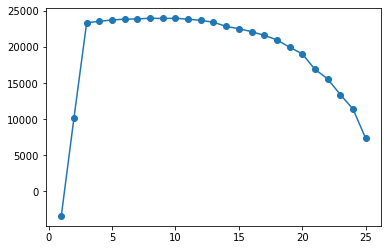

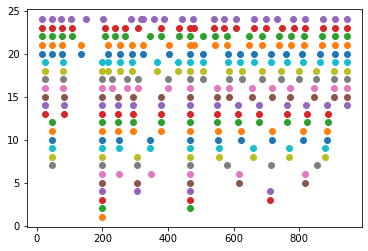

In [112]:
plt.plot(np.arange(1,init.max_bumps()+1), iterative_results.likelihoods,'o-')
plt.show()
for nbump in np.arange(init.max_bumps()):
    times = init.mean_bump_times(iterative_results.sel(n_bumps=nbump),time=False)
    plt.plot(times[:-1], np.repeat(nbump, len(times)-1),'o')


Mean vs mnedian?

In [ ]:
import itertools
bump_loo_results = [iterative_results.sel(n_bumps=init.max_bumps()-1)]

i = 1
for n_bumps in np.arange(init.max_bumps()-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests = xr.concat(bump_loo_results, dim="n_bumps")
bests = bests.assign_coords({"n_bumps": np.arange(9,0,-1)})
bests = bests.squeeze('iteration')
#bests.to_netcdf('bests.nc')
bests

Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Estimating parameters for 24 bumps model
Parameters estim

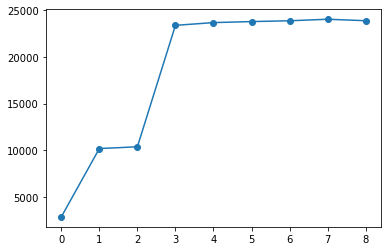

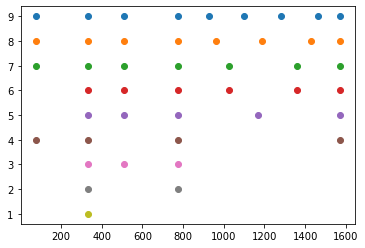

In [108]:
plt.plot(np.arange(9), bests.likelihoods[::-1],'o-')
plt.show()
for nbump in np.arange(9,0,-1):
    times = init.mean_bump_times(bests.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
